# Titanic V0.2 - Parameters optimization (Kaggle score: 0.79425)

In [723]:
from IPython.display import Image
Image(url= "https://nundo.fr/wp-content/uploads/2019/07/titanic_historical_society_homepage_harley_crossley.jpg")

## Import librairies and data

In [650]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

df = pd.read_csv('Datas/train.csv')
test = pd.read_csv('Datas/test.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing values & Features engineering

### On train set

In [651]:
# Missing values
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Cabin'] = df['Cabin'].fillna('NoData')

# This feature engineering choices comes from EDA i made
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['isTitled'] = df['Title'].apply(lambda x: 1 if x in ['Countess','Don','Dr','Jonkheer','Lady','Major','Master','Sir'] else 0) 

df['isWoman'] = np.where(df['Sex'] == 'female', 1, 0)

df['howAge'] = pd.cut(df['Age'], bins=10, labels=False)
df['howAge'] = df['howAge'].apply(lambda x: 6 if x in [6, 7, 8, 9] else x) 

df['sizeFamily'] = df['SibSp'] + df['Parch']
df['sizeFamily'] = df['sizeFamily'].apply(lambda x: (x == 1 and 1) or (x == 2 and 2) or (x in [3,4,5] and 3) or (x > 5 and 4) or 0)

ticket = (df['Ticket'].value_counts() > 1).reset_index()
ticket = ticket[ticket['Ticket'] == True]['index'].tolist()
df['isTicketMulti'] = df['Ticket'].apply(lambda x: 1 if x in ticket else 0)

df['Fare'] = pd.qcut(df['Fare'], 8, labels=False)
fare = {0:0, 1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:3}
df['Fare'] = df['Fare'].replace(fare)

df['isCabin'] = np.where(df['Cabin'] != 'NoData', 1, 0)

df = df.join(pd.get_dummies(df['Embarked'], drop_first=True))

to_drop = ['Name','Title','Sex','Age','SibSp','Parch', 'Ticket','Cabin', 'Embarked']
df = df.drop(to_drop, axis=1)

df.head()

,PassengerId,Survived,Pclass,Fare,isTitled,isWoman,howAge,sizeFamily,isTicketMulti,isCabin,Q,S
0,1,0,3,0,0,0,2,1,0,0,0,1
1,2,1,1,3,0,1,4,1,0,1,0,0
2,3,1,3,0,0,1,3,0,0,0,0,1
3,4,1,1,2,0,1,4,1,1,1,0,1
4,5,0,3,0,0,0,4,0,0,0,0,1


### Same on test set

In [657]:
# Missing values
test['Age'] = test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])
test['Cabin'] = test['Cabin'].fillna('NoData')
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.mean()))

# This feature engineering choices comes from EDA i made
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['isTitled'] = test['Title'].apply(lambda x: 1 if x in ['Countess','Don','Dr','Jonkheer','Lady','Major','Master','Sir'] else 0) 

test['isWoman'] = np.where(test['Sex'] == 'female', 1, 0)

test['howAge'] = pd.cut(test['Age'], bins=10, labels=False)
test['howAge'] = test['howAge'].apply(lambda x: 6 if x in [6, 7, 8, 9] else x) 

test['sizeFamily'] = test['SibSp'] + test['Parch']
test['sizeFamily'] = test['sizeFamily'].apply(lambda x: (x == 1 and 1) or (x == 2 and 2) or (x in [3,4,5] and 3) or (x > 5 and 4) or 0)

ticket = (test['Ticket'].value_counts() > 1).reset_index()
ticket = ticket[ticket['Ticket'] == True]['index'].tolist()
test['isTicketMulti'] = test['Ticket'].apply(lambda x: 1 if x in ticket else 0)

test['Fare'] = pd.qcut(test['Fare'], 8, labels=False)
fare = {0:0, 1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:3}
test['Fare'] = test['Fare'].replace(fare)

test['isCabin'] = np.where(test['Cabin'] != 'NoData', 1, 0)

test = test.join(pd.get_dummies(test['Embarked'], drop_first=True))

to_drop = ['Name','Title','Sex','Age','SibSp','Parch', 'Ticket','Cabin', 'Embarked']
test = test.drop(to_drop, axis=1)

## Machine learning

In [659]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.preprocessing import StandardScaler

In [660]:
# Specificity is recall of the negative class. 
# How much of 'not survived' are captured with 'not survived' predictions.

### First strategy: Work with splitted data

In [661]:
from sklearn.model_selection import train_test_split
X, y = df.drop(['PassengerId', 'Survived'], axis=1), df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#X_train.shape >>> (668, 10)
#X_test.shape >>> (223, 10)

In [662]:
# Returns accuracy, specificity + prints confusion matrix
def model_scores(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    
    matrix = confusion_matrix(y_test, model.predict(X_test))
    specificity = matrix[0,0] / (matrix[0,0] + matrix[0,1])
    
    print(f">>> {str(model).split('(')[0]} <<<")
    print(f'Confusion Matrix:\n{matrix}')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'Specificity: {specificity}\n')
    
    return str(model).split('(')[0], model.score(X_test, y_test), specificity

In [663]:
# To find best parameters, i used for loop as manual GridSearchCV.
# Best param for this configuration: n_neighbors=3
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf_, clf_acc, clf_spe = model_scores(clf)

# Best param for this configuration: C=1
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1, solver='liblinear')
lr_, lr_acc, lr_spe = model_scores(lr)

# Best param for this configuration: C=1
from sklearn.svm import LinearSVC
svc = LinearSVC(C=1, max_iter=1e6)
svc_, svc_acc, svc_spe = model_scores(svc)

# Best param for this configuration: max_depth=4
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree_, tree_acc, tree_spe = model_scores(tree)

# First param: n_estimators=5, max_features=6, max_depth=4 (for Specificity)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, max_features=6, max_depth=4, random_state=0)
forest_, forest_acc, forest_spe = model_scores(forest)

# Second param: n_estimators=1, max_features=7, max_depth=4 (for Accuracy)
forest1 = RandomForestClassifier(n_estimators=1, max_features=7, max_depth=4, random_state=0)
forest1_, forest1_acc, forest1_spe = model_scores(forest1)

# Best param for this configuration: max_depth=3, learning_rate=0.01, (n_estimators=100)
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(max_depth=3, learning_rate=0.01, random_state=0)
gbc_, gbc_acc, gbc_spe = model_scores(gbc)

# First param: hidden_layer_sizes=[10, 10], alpha=1
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10,10], alpha=1, random_state=0)
mlp_, mlp_acc, mlp_spe = model_scores(mlp)

# More: hidden_layer_sizes=10,alpha=0.0001 // hidden_layer_sizes=20,alpha=1 // hidden_layer_sizes=[10,10],alpha=0
mlp1 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10,10], alpha=0, random_state=0)
mlp1_, mlp1_acc, mlp1_spe = model_scores(mlp1)

# Neural networks should work better with standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
mlp_sc_, mlp_sc_acc, mlp_sc_spe = model_scores(mlp, X_train=X_train_sc, X_test=X_test_sc)

>>> KNeighborsClassifier <<<
Confusion Matrix:
[[123  16]
 [ 25  59]]
Accuracy: 0.8161434977578476
Specificity: 0.8848920863309353

>>> LogisticRegression <<<
Confusion Matrix:
[[115  24]
 [ 21  63]]
Accuracy: 0.7982062780269058
Specificity: 0.8273381294964028

>>> LinearSVC <<<
Confusion Matrix:
[[116  23]
 [ 23  61]]
Accuracy: 0.7937219730941704
Specificity: 0.8345323741007195

>>> DecisionTreeClassifier <<<
Confusion Matrix:
[[126  13]
 [ 28  56]]
Accuracy: 0.8161434977578476
Specificity: 0.9064748201438849

>>> RandomForestClassifier <<<
Confusion Matrix:
[[130   9]
 [ 31  53]]
Accuracy: 0.820627802690583
Specificity: 0.935251798561151

>>> RandomForestClassifier <<<
Confusion Matrix:
[[125  14]
 [ 21  63]]
Accuracy: 0.8430493273542601
Specificity: 0.8992805755395683

>>> GradientBoostingClassifier <<<
Confusion Matrix:
[[127  12]
 [ 30  54]]
Accuracy: 0.8116591928251121
Specificity: 0.9136690647482014

>>> MLPClassifier <<<
Confusion Matrix:
[[122  17]
 [ 24  60]]
Accuracy: 0.8161

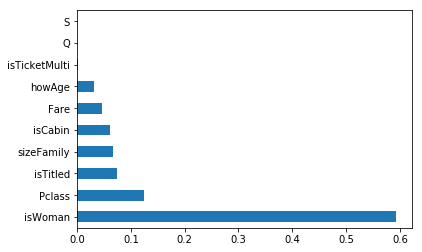

In [664]:
# Check feature importances from DecisionTree
feat_importances = pd.Series(tree.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [665]:
model_names = [clf_, lr_, svc_, tree_, forest_, forest1_, gbc_, mlp_, mlp1_, mlp_sc_]
acc_scores = [clf_acc, lr_acc, svc_acc, tree_acc, forest_acc, forest1_acc, gbc_acc, mlp_acc, mlp1_acc, mlp_sc_acc]
spe_scores = [clf_spe, lr_spe, svc_spe, tree_spe, forest_spe, forest1_spe, gbc_spe, mlp_spe, mlp1_spe, mlp_sc_spe]

model_df = pd.DataFrame({'Model':model_names, 'Accuracy':acc_scores, 'Specificity':spe_scores})
model_df.sort_values(by='Specificity', ascending=False)

,Model,Accuracy,Specificity
4,RandomForestClassifier,0.820628,0.935252
6,GradientBoostingClassifier,0.811659,0.913669
9,MLPClassifier,0.829596,0.913669
3,DecisionTreeClassifier,0.816143,0.906475
5,RandomForestClassifier,0.843049,0.899281
0,KNeighborsClassifier,0.816143,0.884892
7,MLPClassifier,0.816143,0.877698
8,MLPClassifier,0.820628,0.863309
2,LinearSVC,0.793722,0.834532
1,LogisticRegression,0.798206,0.827338


In [666]:
# Scores on train set
models = [clf, lr, svc, tree, forest, forest1, gbc, mlp, mlp1]
for name, model in zip(model_names, models):
    score = round(model.score(X_train, y_train) * 100, 2)
    print(f'{name}: {score}')
print(f'{name} + StandardScaler(): {round(mlp.score(X_train_sc, y_train) * 100, 2)}')

KNeighborsClassifier: 85.18
LogisticRegression: 82.78
LinearSVC: 83.53
DecisionTreeClassifier: 84.73
RandomForestClassifier: 84.28
RandomForestClassifier: 81.74
GradientBoostingClassifier: 83.53
MLPClassifier: 61.38
MLPClassifier: 85.78
MLPClassifier + StandardScaler(): 87.87


In [667]:
# Scores are gloablly better because trained models learn on this "train set".
# Looks like good scores on "validation set" gone bad (as MLPClassifier with 61.38, instead 81.16 on val set).
# Also, these scores will be different if we change random_state in train_test_set function (worst or better).
# From these results, MLP Classifier with StandardScaler() seems to be the best choice.
# For the exercice, i want to make complementary tests using cross validation (KFolds).

### Second strategy: Working with cross validation

In [668]:
def get_cross_val(model, X_train=X_train, y_train=y_train, kfold=kfold, display=False):
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    
    if display == True:
        print(f">>> {str(model).split('(')[0]} <<<")
        print(f'Scores: {scores}')
        print(f'Mean score: {scores.mean()}')
        print(f'Model sensitivity: {scores.max() - scores.min()}\n')
    
    return scores.mean()

In [669]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_score = get_cross_val(clf, display=True)
lr_score = get_cross_val(lr)
svc_score = get_cross_val(svc)
tree_score = get_cross_val(tree)
forest_score = get_cross_val(forest)
forest1_score = get_cross_val(forest1)
gbc_score = get_cross_val(gbc)
mlp_score = get_cross_val(mlp)
mlp1_score = get_cross_val(mlp1)
mlp_sc_score = get_cross_val(mlp, X_train=X_train_sc)

>>> KNeighborsClassifier <<<
Scores: [0.76865672 0.67164179 0.76119403 0.81203008 0.69924812]
Mean score: 0.7425541465604308
Model sensitivity: 0.1403882841431937



In [670]:
from sklearn.model_selection import KFold
kfold1 = KFold(n_splits=5, shuffle=True, random_state=0)

clf_score1 = get_cross_val(clf, kfold=kfold1, display=True)
lr_score1 = get_cross_val(lr, kfold=kfold1)
svc_score1 = get_cross_val(svc, kfold=kfold1)
tree_score1 = get_cross_val(tree, kfold=kfold1)
forest_score1 = get_cross_val(forest, kfold=kfold1)
forest1_score1 = get_cross_val(forest1, kfold=kfold1)
gbc_score1 = get_cross_val(gbc, kfold=kfold1)
mlp_score1 = get_cross_val(mlp, kfold=kfold1)
mlp1_score1 = get_cross_val(mlp1, kfold=kfold1)
mlp_sc_score1 = get_cross_val(mlp, X_train=X_train_sc, kfold=kfold1)

>>> KNeighborsClassifier <<<
Scores: [0.76119403 0.7761194  0.82089552 0.7518797  0.76691729]
Mean score: 0.7754011895410168
Model sensitivity: 0.06901582313993948



In [671]:
model_names = [clf_, lr_, svc_, tree_, forest_, forest1_, gbc_, mlp_, mlp1_, mlp_sc_]
model_scores = [clf_score, lr_score, svc_score, tree_score, forest_score, forest1_score, gbc_score, mlp_score, mlp1_score, mlp_sc_score]
model_scores1 = [clf_score1, lr_score1, svc_score1, tree_score1, forest_score1, forest1_score1, gbc_score1, mlp_score1, mlp1_score1, mlp_sc_score1]

model_df1 = pd.DataFrame({'Model':model_names, 'StratifiedKFold':model_scores, 'KFold':model_scores1})
model_df1

,Model,StratifiedKFold,KFold
0,KNeighborsClassifier,0.742554,0.775401
1,LogisticRegression,0.824834,0.815857
2,LinearSVC,0.826349,0.823286
3,DecisionTreeClassifier,0.832308,0.842801
4,RandomForestClassifier,0.815913,0.829301
5,RandomForestClassifier,0.820402,0.814308
6,GradientBoostingClassifier,0.829346,0.815846
7,MLPClassifier,0.815902,0.815834
8,MLPClassifier,0.811390,0.809831
9,MLPClassifier,0.805409,0.799372


### Model selection

In [672]:
model_df['Model'][5] = 'RandomForestClassifier1'
model_df['Model'][8] = 'MLPClassifier1'
model_df['Model'][9] = 'MLPClassifier2'

model_df1['Model'][5] = 'RandomForestClassifier1'
model_df1['Model'][8] = 'MLPClassifier1'
model_df1['Model'][9] = 'MLPClassifier2'

In [673]:
model_df

,Model,Accuracy,Specificity
0,KNeighborsClassifier,0.816143,0.884892
1,LogisticRegression,0.798206,0.827338
2,LinearSVC,0.793722,0.834532
3,DecisionTreeClassifier,0.816143,0.906475
4,RandomForestClassifier,0.820628,0.935252
5,RandomForestClassifier1,0.843049,0.899281
6,GradientBoostingClassifier,0.811659,0.913669
7,MLPClassifier,0.816143,0.877698
8,MLPClassifier1,0.820628,0.863309
9,MLPClassifier2,0.829596,0.913669


In [674]:
select = model_df.set_index('Model').join(model_df1.set_index('Model'), on='Model')
select['Total'] = (select['Accuracy'] + select['Specificity'] + select['StratifiedKFold'] + select['KFold'])/4

select.sort_values(by='Total', ascending=False)

,Accuracy,Specificity,StratifiedKFold,KFold,Total
Model,,,,,
RandomForestClassifier,0.820628,0.935252,0.815913,0.829301,0.850273
DecisionTreeClassifier,0.816143,0.906475,0.832308,0.842801,0.849432
RandomForestClassifier1,0.843049,0.899281,0.820402,0.814308,0.844260
GradientBoostingClassifier,0.811659,0.913669,0.829346,0.815846,0.842630
MLPClassifier2,0.829596,0.913669,0.805409,0.799372,0.837012
MLPClassifier,0.816143,0.877698,0.815902,0.815834,0.831394
MLPClassifier1,0.820628,0.863309,0.811390,0.809831,0.826290
LinearSVC,0.793722,0.834532,0.826349,0.823286,0.819472
LogisticRegression,0.798206,0.827338,0.824834,0.815857,0.816559


In [675]:
# If I had to choose, my best choice would be for RandomForestClassifier
# But we have time and i wish i can get a better score on Kaggle Competition Titanic.
# I choose to blend predictions of models (without KNeighborsClassifier, because poor score with KFold)

## Predictions

### Blend results

In [694]:
# It needs a odd number of models if we don't want equality in predictions.
# Other strategy, add coefficients to models, but this is an other level!

In [715]:
X_train = df.drop(['PassengerId', 'Survived'], axis=1)
y_train = df['Survived']
X_test = test.drop('PassengerId', axis=1)

# For readability, i charged again models with optimized parameters
lr = LogisticRegression(C=1, solver='liblinear')
svc = LinearSVC(C=1, max_iter=1e6)
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
forest = RandomForestClassifier(n_estimators=5, max_features=6, max_depth=4, random_state=0)
forest1 = RandomForestClassifier(n_estimators=1, max_features=7, max_depth=4, random_state=0)
gbc = GradientBoostingClassifier(max_depth=3, learning_rate=0.01, random_state=0)
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10,10], alpha=1, random_state=0)
mlp1 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10,10], alpha=0, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

model_selected = [lr, svc, tree, forest, forest1, gbc, mlp, mlp1]
def get_pred(model_selected=model_selected):
    data = []
    for model in model_selected:
        y_pred = model.fit(X_train, y_train).predict(X_test)
        data.append(y_pred.tolist())
    return pd.DataFrame(data).transpose()

In [716]:
mix = get_pred()
mix.head()

# Last add with X_train scaled
y_pred = model.fit(X_train_sc, y_train).predict(X_test_sc)
mix[8] = y_pred

mix['Pred'] = round((mix[0] + mix[1]  + mix[2] + mix[3] + mix[4] + mix[5] + mix[6] + mix[7] + mix[8])/9).astype('int')

mix.head(10)

,0,1,2,3,4,5,6,7,8,Pred
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,1,0
5,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1,0,1
7,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0


### Kaggle Submission file

In [719]:
kaggle = pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": mix['Pred']})
kaggle.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [722]:
pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": mix[4]}).to_csv('submission_forest1.csv', index=False)
pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": mix[2]}).to_csv('submission_tree.csv', index=False)

In [ ]:
# SCORES:
# Blended: 0.77990
# RandomForestClassfier(1): 0.78468
# DecisionTreeClassifier: 0.79425

## Drafts

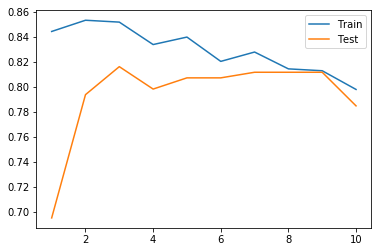

In [288]:
train_acc = []
test_acc = []
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, train_acc, label="Train")
plt.plot(neighbors_settings, test_acc, label="Test")
plt.legend()

In [116]:
#import os
#os.listdir()

#fig, ax = plt.subplots(1, 2, figsize=(15, 3))
#ax[0].plot(df['Age'])
#ax[1].hist(df['Fare'])

#sns.countplot(df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False), hue='Survived', data=df)
#plt.xticks(rotation=45)

#fig, ax = plt.subplots(2, 2, figsize=(15,6))
#sns.countplot(pd.cut(df['Age'], bins=6, labels=False), hue='Survived', data=df, ax=ax[0,0])
#sns.countplot(pd.cut(df['Age'], bins=8, labels=False), hue='Survived', data=df, ax=ax[0,1])
#sns.countplot(pd.cut(df['Age'], bins=10, labels=False), hue='Survived', data=df, ax=ax[1,0])
#sns.countplot(pd.cut(df['Age'], bins=12, labels=False), hue='Survived', data=df, ax=ax[1,1])

#df.groupby(['Title']).agg(['mean', 'count'])['Survived']

#fig, ax = plt.subplots(4, 2, figsize=(15,10))
#sns.countplot(pd.cut(df['Fare'], bins=6, labels=False), hue='Survived', data=df, ax=ax[0,0])
#sns.countplot(pd.cut(df['Fare'], bins=8, labels=False), hue='Survived', data=df, ax=ax[0,1])
#sns.countplot(pd.cut(df['Fare'], bins=10, labels=False), hue='Survived', data=df, ax=ax[1,0])
#sns.countplot(pd.cut(df['Fare'], bins=12, labels=False), hue='Survived', data=df, ax=ax[1,1])
#sns.countplot(pd.qcut(df['Fare'], 6, labels=False), hue='Survived', data=df, ax=ax[2,0])
#sns.countplot(pd.qcut(df['Fare'], 8, labels=False), hue='Survived', data=df, ax=ax[2,1])
#sns.countplot(pd.qcut(df['Fare'], 10, labels=False), hue='Survived', data=df, ax=ax[3,0])
#sns.countplot(pd.qcut(df['Fare'], 12, labels=False), hue='Survived', data=df, ax=ax[3,1])